In [1]:
import math
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
from IPython import display as disp
from torch.optim.lr_scheduler import StepLR

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [2]:
train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])

test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])

In [3]:
# helper function to make getting another batch of data easier
def cycle(iterable):
    while True:
        for x in iterable:
            yield x

class_names = ['apple','aquarium_fish','baby','bear','beaver','bed','bee','beetle','bicycle','bottle','bowl','boy','bridge','bus','butterfly','camel','can','castle','caterpillar','cattle','chair','chimpanzee','clock','cloud','cockroach','couch','crab','crocodile','cup','dinosaur','dolphin','elephant','flatfish','forest','fox','girl','hamster','house','kangaroo','computer_keyboard','lamp','lawn_mower','leopard','lion','lizard','lobster','man','maple_tree','motorcycle','mountain','mouse','mushroom','oak_tree','orange','orchid','otter','palm_tree','pear','pickup_truck','pine_tree','plain','plate','poppy','porcupine','possum','rabbit','raccoon','ray','road','rocket','rose','sea','seal','shark','shrew','skunk','skyscraper','snail','snake','spider','squirrel','streetcar','sunflower','sweet_pepper','table','tank','telephone','television','tiger','tractor','train','trout','tulip','turtle','wardrobe','whale','willow_tree','wolf','woman','worm',]

train_loader = torch.utils.data.DataLoader(
    torchvision.datasets.CIFAR100('data', train=True, download=True, transform=train_transform),
    batch_size=256, drop_last=True
)

test_loader = torch.utils.data.DataLoader(
    torchvision.datasets.CIFAR100('data', train=False, download=True, transform=test_transform),
    batch_size=256, drop_last=True
)

train_iterator = iter(cycle(train_loader))
test_iterator = iter(cycle(test_loader))

print(f'> Size of training dataset {len(train_loader.dataset)}')
print(f'> Size of test dataset {len(test_loader.dataset)}')

Files already downloaded and verified
Files already downloaded and verified
> Size of training dataset 50000
> Size of test dataset 10000


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

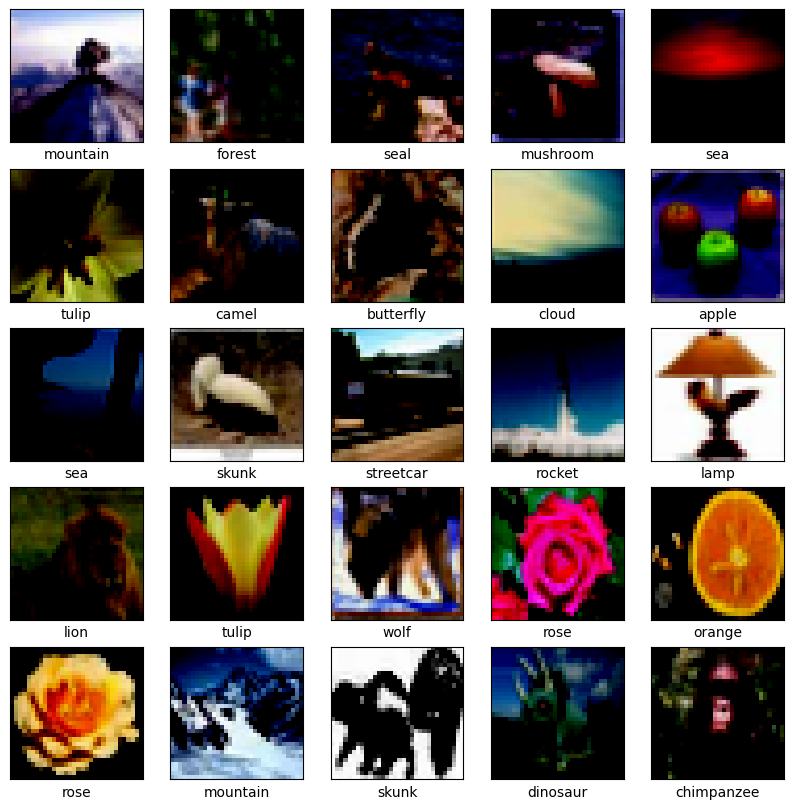

In [4]:
###### plt.rcParams['figure.dpi'] = 70
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    img = test_loader.dataset[i][0].numpy().transpose(1, 2, 0)
    plt.imshow(img)
    plt.xlabel(class_names[test_loader.dataset[i][1]])
plt.show()

In [5]:
# Residiual block used from deep learning practical 3
class ResidualBlock(nn.Module):
    def __init__(self, n):
        super().__init__()
        self.block = nn.Sequential(
            nn.Conv2d(n, n, 3, 1, 1),
            nn.BatchNorm2d(n),
            nn.ReLU(),
            nn.Conv2d(n, n, 3, 1, 1),
            nn.BatchNorm2d(n)
        )

    def forward(self, x):
        return torch.relu(x + self.block(x))

# ConvNet model inspired by https://towardsdatascience.com/how-to-reduce-training-parameters-in-cnns-while-keeping-accuracy-99-a213034a9777
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        
        # Block 1
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=2, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(num_features=2)
        self.relu1 = nn.ReLU()
        
        # Block 2
        self.conv2 = nn.Conv2d(in_channels=2, out_channels=16, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(num_features=16)
        self.relu2 = nn.ReLU()
        self.residual_block1 = ResidualBlock(16)
        
        # Block 3
        self.conv3 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.bn3 = nn.BatchNorm2d(num_features=32)
        self.relu3 = nn.ReLU()
        self.residual_block2 = ResidualBlock(32)
        
        # Block 4
        self.conv4 = nn.Conv2d(in_channels=32, out_channels=100, kernel_size=3, stride=1, padding=1)
        self.bn4 = nn.BatchNorm2d(num_features=100)
        self.relu4 = nn.ReLU()
        
        # Block 5
        self.conv5 = nn.Conv2d(in_channels=100, out_channels=40, kernel_size=3, stride=1, padding=1)
        self.bn5 = nn.BatchNorm2d(num_features=40)
        self.relu5 = nn.ReLU()

        # Global Average Pooling
        self.global_avg_pool = nn.AdaptiveAvgPool2d((1, 1))

        # Fully connected layer
        self.fc = nn.Linear(40, 100)  # CIFAR-100 has 100 classes

    def forward(self, x):
        # Applying layers with ReLU activation
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = F.relu(self.bn3(self.conv3(x)))
        x = F.relu(self.bn4(self.conv4(x)))
        x = F.relu(self.bn5(self.conv5(x)))

        # Global Average Pooling and Fully connected layer
        x = self.global_avg_pool(x)
        x = x.view(-1, 40)  # Flatten the tensor
        x = self.fc(x)
        return x

# Initialize the model
model = ConvNet().to(device)


# Print the number of parameters
print(f'> Number of parameters: {sum(p.numel() for p in model.parameters() if p.requires_grad)}')

> Number of parameters: 97748


Epoch: 1, Steps: 500, Train Loss: 3.8420, Train Acc: 0.1060, Test Acc: 0.1837
Epoch: 2, Steps: 1000, Train Loss: 3.1076, Train Acc: 0.2330, Test Acc: 0.2796
Epoch: 3, Steps: 1500, Train Loss: 2.7470, Train Acc: 0.3041, Test Acc: 0.3330
Epoch: 4, Steps: 2000, Train Loss: 2.5358, Train Acc: 0.3457, Test Acc: 0.3635
Epoch: 5, Steps: 2500, Train Loss: 2.3970, Train Acc: 0.3758, Test Acc: 0.3783
Epoch: 6, Steps: 3000, Train Loss: 2.3044, Train Acc: 0.3944, Test Acc: 0.3972
Epoch: 7, Steps: 3500, Train Loss: 2.2331, Train Acc: 0.4115, Test Acc: 0.4100
Epoch: 8, Steps: 4000, Train Loss: 2.1755, Train Acc: 0.4219, Test Acc: 0.4019
Epoch: 9, Steps: 4500, Train Loss: 2.1310, Train Acc: 0.4340, Test Acc: 0.4268
Epoch: 10, Steps: 5000, Train Loss: 2.0913, Train Acc: 0.4418, Test Acc: 0.4349
Epoch: 11, Steps: 5500, Train Loss: 2.0608, Train Acc: 0.4479, Test Acc: 0.4359
Epoch: 12, Steps: 6000, Train Loss: 2.0268, Train Acc: 0.4552, Test Acc: 0.4338
Epoch: 13, Steps: 6500, Train Loss: 2.0025, Train 

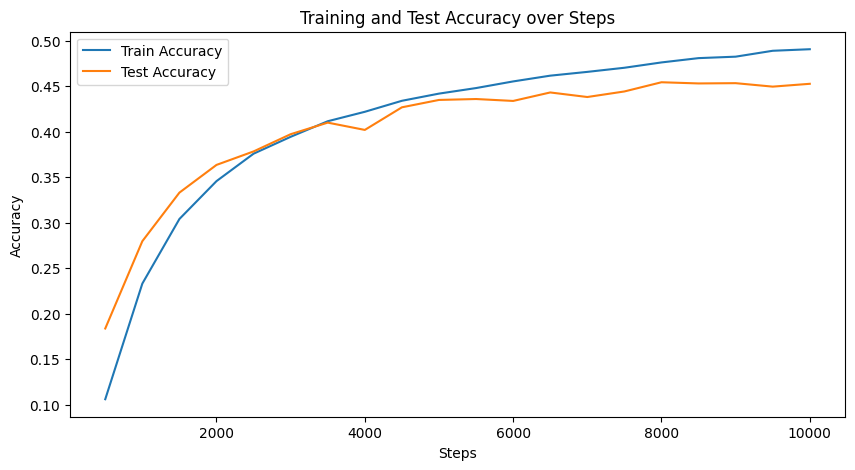

Final Training Loss Mean: 2.2570, Std: 0.4773
Final Training Accuracy Mean: 0.4094, Std: 0.0955
Final Test Accuracy Mean: 0.4033, Std: 0.0674


In [6]:
# Loss Function and Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.02)

# Learning Rate Scheduler
scheduler = StepLR(optimizer, step_size=20, gamma=0.1)

plot_data = []
steps = 0
max_steps = 10000

epoch_train_losses = []
epoch_train_accuracies = []
epoch_test_accuracies = []

for epoch in range(20):
    train_loss_arr = np.zeros(0)
    train_acc_arr = np.zeros(0)
    test_acc_arr = np.zeros(0)


    for i in range(500):  # iterating through 500 batches per epoch
        x, t = next(train_iterator)
        x, t = x.to(device), t.to(device)

        optimizer.zero_grad()
        p = model(x)
        loss = criterion(p, t)
        loss.backward()
        optimizer.step()

        steps += 1
        if steps >= max_steps:
            break

        train_loss_arr = np.append(train_loss_arr, loss.item())
        pred = p.argmax(dim=1, keepdim=True)
        train_acc_arr = np.append(train_acc_arr, pred.eq(t.view_as(pred)).float().mean().item())

    # Update learning rate
    scheduler.step()

    # Test accuracy
    with torch.no_grad():
        for x, t in test_loader:
            x, t = x.to(device), t.to(device)
            p = model(x)
            pred = p.argmax(dim=1, keepdim=True)
            test_acc_arr = np.append(test_acc_arr, pred.eq(t.view_as(pred)).float().mean().item())

    print(f'Epoch: {epoch+1}, Steps: {steps}, Train Loss: {train_loss_arr.mean():.4f}, '
          f'Train Acc: {train_acc_arr.mean():.4f}, Test Acc: {test_acc_arr.mean():.4f}')

    plot_data.append([steps, train_acc_arr.mean(), test_acc_arr.mean()])
    
    epoch_train_losses.append(train_loss_arr.mean())
    epoch_train_accuracies.append(train_acc_arr.mean())
    epoch_test_accuracies.append(test_acc_arr.mean())

    if steps >= max_steps:
        break

# Plot training and test accuracy
plt.figure(figsize=(10, 5))
plt.plot([x[0] for x in plot_data], [x[1] for x in plot_data], label="Train Accuracy")
plt.plot([x[0] for x in plot_data], [x[2] for x in plot_data], label="Test Accuracy")
plt.xlabel('Steps')
plt.ylabel('Accuracy')
plt.title('Training and Test Accuracy over Steps')
plt.legend()
plt.show()

# Compute the standard deviations
train_loss_std = np.std(epoch_train_losses)
train_acc_std = np.std(epoch_train_accuracies)
test_acc_std = np.std(epoch_test_accuracies)

# Print the final values with means and standard deviations
print(f"Final Training Loss Mean: {np.mean(epoch_train_losses):.4f}, Std: {train_loss_std:.4f}")
print(f"Final Training Accuracy Mean: {np.mean(epoch_train_accuracies):.4f}, Std: {train_acc_std:.4f}")
print(f"Final Test Accuracy Mean: {np.mean(epoch_test_accuracies):.4f}, Std: {test_acc_std:.4f}")

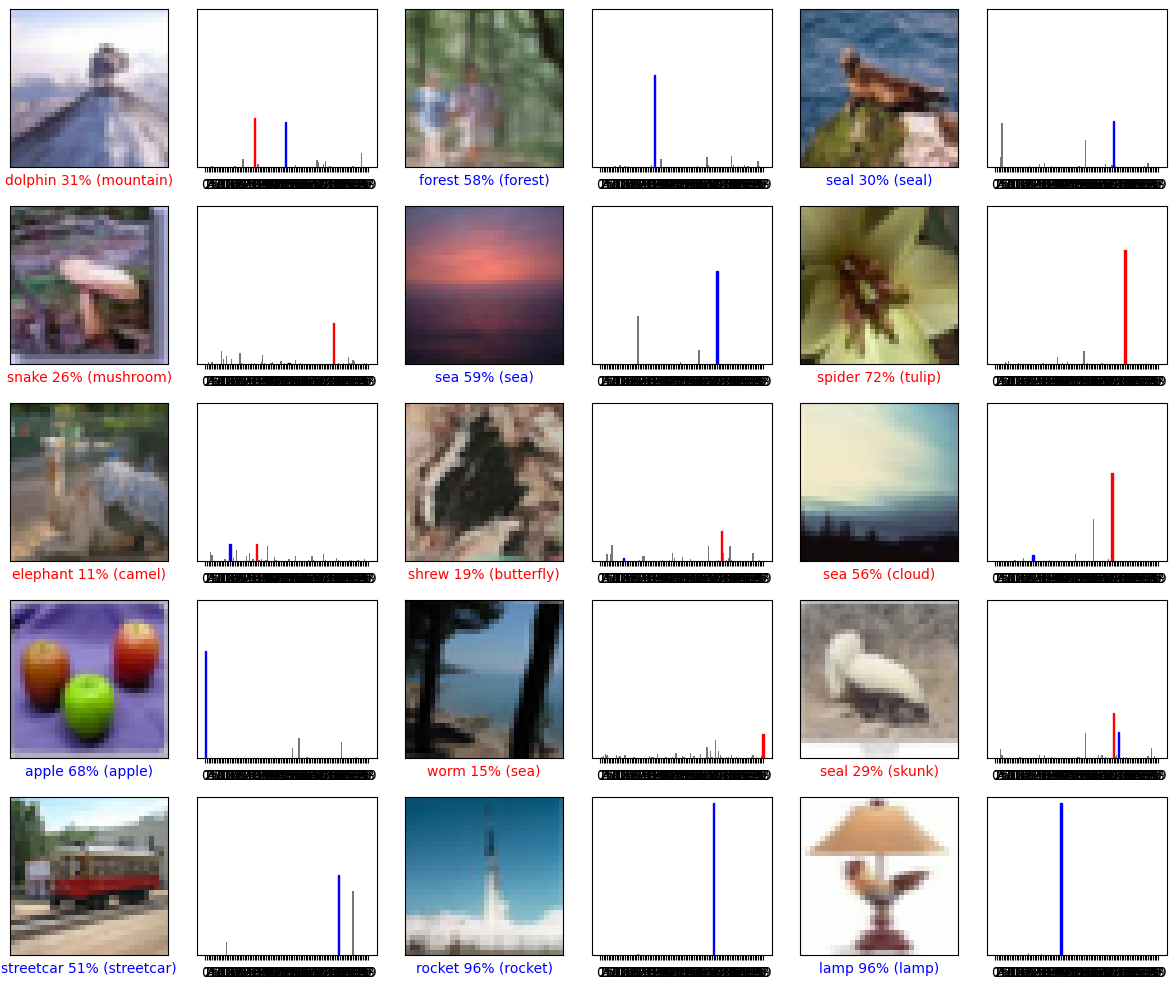

In [7]:
def plot_image(i, predictions_array, true_label, img):
    predictions_array, true_label, img = predictions_array[i], true_label[i], img[i]
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])

    img = img.numpy().transpose(1, 2, 0)
    mean = np.array([0.5, 0.5, 0.5])
    std = np.array([0.5, 0.5, 0.5])
    img = std * img + mean
    img = np.clip(img, 0, 1)

    plt.imshow(img)

    predicted_label = np.argmax(predictions_array)
    if predicted_label == true_label:
        color = 'blue'
    else:
        color = 'red'

    plt.xlabel(f"{class_names[predicted_label]} {100*np.max(predictions_array):2.0f}% ({class_names[true_label]})", color=color)

def plot_value_array(i, predictions_array, true_label):
    predictions_array, true_label = predictions_array[i], true_label[i]
    plt.grid(False)
    plt.xticks(range(100))
    plt.yticks([])
    thisplot = plt.bar(range(100), predictions_array, color="#777777")
    plt.ylim([0, 1])
    predicted_label = np.argmax(predictions_array)

    thisplot[predicted_label].set_color('red')
    thisplot[true_label].set_color('blue')

# Plotting test images with predictions
num_rows = 5
num_cols = 3
num_images = num_rows * num_cols
plt.figure(figsize=(2*2*num_cols, 2*num_rows))

test_images, test_labels = next(test_iterator)
test_images, test_labels = test_images.to(device), test_labels.to(device)
test_preds = torch.softmax(model(test_images), dim=1).cpu().detach().numpy()

for i in range(num_images):
    plt.subplot(num_rows, 2*num_cols, 2*i+1)
    plot_image(i, test_preds, test_labels.cpu().numpy(), test_images.cpu())
    plt.subplot(num_rows, 2*num_cols, 2*i+2)
    plot_value_array(i, test_preds, test_labels.cpu().numpy())

plt.tight_layout()
plt.show()
